## Workshop 4: Supply Chain Case Study Practise

This notebook illustrates Example 20 from Chapter 3 of the textbook Hands-On Mathematical Optimization with Python, Cambridge University Press, 2024.

### 1. Installing and Importing Packages 

We first need to pull in all the packages we will be using. Pyomo is a Python-based, open-source optimization modelling language with a diverse set of optimization capabilities. For more information, see the Pyomo [documentation](https://pyomo.readthedocs.io/en/stable/).

In [11]:
import matplotlib.pyplot as plt
from pyomo.environ import *
import numpy as np
import numpy as np
import platform
from time import perf_counter as pc

# Ipopt solver setup for Windows or Linux
def setup_solver():
    os_name = platform.system()
    if os_name == "Windows":
        return "solver/ipopt.exe"
    elif os_name == "Linux":
        !chmod +x "solver/ipopt"
        return "solver/ipopt"


solver_executable = setup_solver()

### 2. Problem description

Consider the problem of a supplier facing the task of fulfilling specific customer demands with minimal costs while simultaneously deciding how many facilities to build and where. In terms of data, we are given a set $I$ of customers, a set $J$ of possible locations, the cost $c_j$ of building facility $j$, and the cost $h_{ij}$ incurred to satisfy the demands of customer $i$ at facility $j$.


#### a. MILP formulation


\begin{align*}
    \min \quad & \sum_{j \in J} c_j x_j + \sum_{i \in I} \sum_{j \in J} h_{ij} y_{ij} \\
    \text{s.t.} \quad & \sum_{j \in J} y_{ij} = 1 \qquad \forall \, i \in I & \text{(every customer is served)} \\
    & y_{ij} \leq x_{j} \qquad \forall \, i\in I, \, \forall \, j \in J & \text{(facility built before use)} \\
    & x_j \in \{0,1\} \qquad \forall \, j \in J \\
    & y_{ij} \in \{0,1\} \qquad \forall \, i \in I, \, \forall \, j \in J.
\end{align*}

\begin{align*}
    x_j := 
    \begin{cases}
        1 & \text{if facility $j$ is built,} \\
        0 & \text{otherwise,} \\
    \end{cases}
    \quad \quad
    y_{ij} := 
    \begin{cases}
        1 & \text{if customer $i$ is served at facility $j$,} \\
        0 & \text{otherwise.} \\
    \end{cases}
\end{align*}

In [12]:
def FacilityLocationCommon(installation, service):
    # Create a concrete model for the facility location problem
    model = ConcreteModel("Facility location")
    
    # Initialize sets for facilities and customers based on input data
    model.facilities = Set(initialize=range(len(installation)))
    model.customers = Set(initialize=range(len(service)))

    # Define binary decision variables for facilities (x) and customer-service relationships (y)
    model.x = Var(model.facilities, within=Binary)  # x[j]: 1 if facility j is built, 0 otherwise
    model.y = Var(model.customers, model.facilities, within=Binary)  # y[i,j]: 1 if customer i is served by facility j, 0 otherwise

    # Objective function: minimize the total cost of facilities and service
    @model.Objective(sense=minimize)
    def obj(model):
        return (
            sum(installation[j] * model.x[j] for j in model.facilities) +  # Cost of building facilities
            sum(service[i][j] * model.y[i, j] for i in model.customers for j in model.facilities)  # Cost of serving customers
        )

    # Constraint: each customer must be served by exactly one facility
    @model.Constraint(model.customers)
    def ChooseOneFacility(model, i):
        return sum(model.y[i, j] for j in model.facilities) == 1

    return model


def FacilityLocationStrong(installation, service):
    # Create a strong model by using the common facility location model
    model = FacilityLocationCommon(installation, service)
    model.name += " strong model"  # Append to the model name for identification

    # Constraint: if customer i is served by facility j, then facility j must be open
    @model.Constraint(model.customers, model.facilities)
    def ServeIfOpen(model, i, j):
        return model.y[i, j] <= model.x[j]

    return model


def GetSolution(model):
    # Extract and return the solution for the decision variables and objective value
    X = [model.x[j]() > 0.5 for j in model.facilities]  # Determine which facilities are built
    Y = [[model.y[i, j]() > 0.5 for j in model.facilities] for i in model.customers]  # Determine service relationships
    return X, Y, model.obj()  # Return built facilities, service matrix, and objective value


We introduce functions to generate random instances for the problem and to then visualize the optimal solution.

In [13]:
def GenerateFacilityLocationInstance(nofFacilities, nofCustumers):
    facilities = range(nofFacilities)
    customers = range(nofCustumers)
    xC = np.random.randint(0, 100, nofCustumers)
    yC = np.random.randint(0, 100, nofCustumers)
    xF = np.random.randint(0, 100, nofFacilities)
    yF = np.random.randint(0, 100, nofFacilities)

    installation = np.random.randint(1000, 2000, nofFacilities)

    def dist(i, j):
        return (xC[i] - xF[j]) ** 2 + (yC[i] - yF[j]) ** 2

    service = [[dist(i, j) for j in facilities] for i in customers]

    return installation, service, xC, yC, xF, yF


def ShowFacilityLocation(xC, yC, xF, yF, X=[], Y=[], value=None, title=None, ax=None):
    if ax is None:
        ax = plt.gca()
    [
        ax.plot([xC[i], xF[j]], [yC[i], yF[j]], "g-")
        for j in range(len(X))
        if X[j]
        for i in range(len(Y))
        if Y[i][j]
    ]
    ax.plot(xC, yC, "o")
    ax.plot(xF, yF, "s")
    if title:
        ax.set_title(title)
    elif value:
        ax.set_title(f"Optimal value: {value}")

We then generate an instance of the problem with 10 facilities and 100 customers and initialize both a strong and a weak Pyomo models.

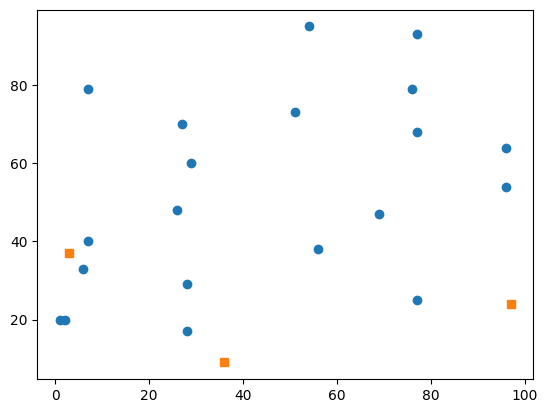

In [27]:
np.random.seed(2026)

installation, service, xC, yC, xF, yF = GenerateFacilityLocationInstance(3,20)
ShowFacilityLocation(xC, yC, xF, yF)

strong = FacilityLocationStrong(installation, service)

In [28]:
def Solve(solver, model):
    t = pc()
    _ = solver.solve(model)
    t = pc() - t
    X, Y, v = GetSolution(model)
    title = f"Time to solve: {t:.3f} (s)"
    return X, Y, v, title

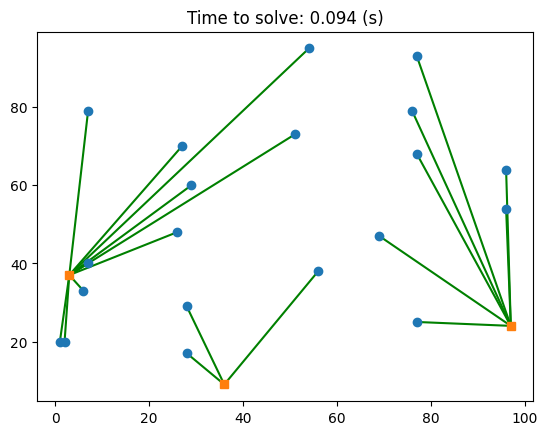

In [29]:
solver = SolverFactory("ipopt", executable=solver_executable)
ShowFacilityLocation(xC, yC, xF, yF, *Solve(solver, strong))